### Transfer Learning

Some references:

- Transfer Learning with TF 2.0 (https://towardsdatascience.com/transfer-learning-with-tf-2-0-ff960901046d)
- How to Classify Photos of Dogs and Cats (with 97% accuracy) (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)
- Models pre-trained on ImageNet (https://keras.io/applications/)

Dataset: Dogs vs. Cats dataset - https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

In [2]:
NCLASSES = 2
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3
BATCH_SIZE = 16

DATA_SET_COUNT = 2500
TEST_SET_COUNT = 2000
TRAIN_SET_COUNT = (DATA_SET_COUNT) * 0.8
VAL_SET_COUNT = (DATA_SET_COUNT) * 0.2
print(TRAIN_SET_COUNT, VAL_SET_COUNT)

# Especificar ponto a, b ou c
ponto = "a"

2000.0 500.0


Load a model from keras database (https://keras.io/applications/) with weights trained on ImageNet

Note that the *image_top* parameter is set to *true*. This implies that we are only keeping the convolutional layers of the network

In [3]:
if ponto == "a":
    base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_tensor=None, input_shape=None, pooling=None)
else:
    base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None)

print(base_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Freeze the preloaded weights, these won't be used for training
comment the line below to train the full network

In [4]:
if ponto == "c":
    base_model.trainable = True
else:
    base_model.trainable = False

Add new layers to the top of the network

Global Average Pooling (GAP) performs an average for each of the feature maps. Assuming the last conv layer is 3x3x256, we have 256 feature maps. Global average pooling is a layer with 256 values, each being the average of a feature map.

Original paper for Global Average Pooling: Network In Network, Min Lin1, Qiang Chen, Shuicheng Yan (https://arxiv.org/pdf/1312.4400.pdf). Note the GAP is not the main theme of the paper.

In [5]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)
print(model_3.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, None, None, 9 55296       activation_27[0][0]              
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, None, None, 9 288         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, None, 9 0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, None, None, 3 995328      mixed2[0][0]                     
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, None, None, 9 82944       activation_28[0][0]              
__________

Auxiliary function for loading the dataset

In [6]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Load the dataset, replace the path with your own location of the dataset

In [7]:
data_dir = pathlib.Path('train/')
  
classNames = np.array(os.listdir(data_dir))
print(classNames)

AUTOTUNE = tf.data.experimental.AUTOTUNE
'''
listset = tf.data.Dataset.list_files("train/*/*.jpg")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
'''
listset = tf.data.Dataset.list_files("train/cats/*.jpg")
catset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


listset = tf.data.Dataset.list_files("train/dogs/*.jpg")
dogset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



['cats' 'dogs']


Split the dataset into training and validation sets

In [8]:
catset = catset.prefetch(buffer_size=AUTOTUNE)

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)

class_train_size = int(train_size / 2)
class_val_size = int(val_size / 2)

train_catset = catset.take(class_train_size)
train_catset = train_catset.shuffle(buffer_size = class_train_size)
#train_catset = train_catset.batch(batch_size=BATCH_SIZE)
#train_catset = train_catset.repeat();
val_catset = train_catset.skip(class_val_size)
#val_catset = val_dataset.batch(batch_size=BATCH_SIZE)
#val_catset = val_dataset.repeat()


dogset = dogset.prefetch(buffer_size=AUTOTUNE)

train_dogset = dogset.take(class_train_size)
train_dogset = train_dogset.shuffle(buffer_size = class_train_size)
#train_dogset = train_dogset.batch(batch_size=BATCH_SIZE)
#train_dogset = train_dogset.repeat();
val_dogset = train_dogset.skip(class_val_size)
#val_dogset = val_dogset.batch(batch_size=BATCH_SIZE)
#val_dogset = val_dogset.repeat()


train_dataset = train_catset.concatenate(train_dogset)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.repeat()

val_dataset = val_catset.concatenate(val_dogset)
val_dataset = val_dataset.shuffle(buffer_size = train_size)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.repeat()

#train_dataset = dataset.take(train_size)
#train_dataset = train_dataset.shuffle(buffer_size = train_size)
#train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
#train_dataset = train_dataset.repeat();
#val_dataset = dataset.skip(train_size)
#val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
#val_dataset = val_dataset.repeat();


Load the test set

In [9]:
testset = tf.data.Dataset.list_files("test/*/*.jpg")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)



Show a batch of images from the dataset

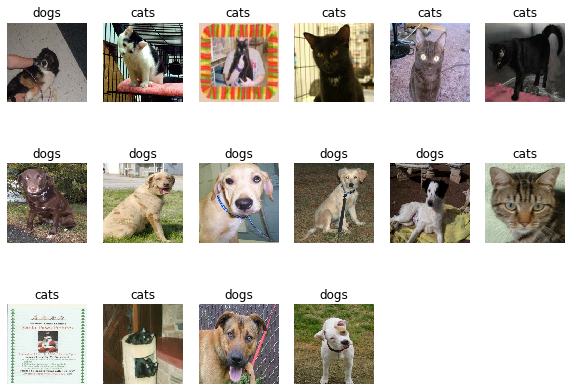

In [10]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(train_dataset))  
show_batch(image_batch, label_batch.numpy())

Train the model for 20 epochs

In [11]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
history = model_3.fit(train_dataset, epochs=20, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

Train for 125.0 steps, validate for 31.25 steps
Epoch 1/20
125/125 [==============================] - 24s 194ms/step - loss: 0.3735 - categorical_accuracy: 0.8640 - val_loss: 0.0297 - val_categorical_accuracy: 0.9922
Epoch 2/20
125/125 [==============================] - 16s 127ms/step - loss: 0.2918 - categorical_accuracy: 0.8730 - val_loss: 0.0508 - val_categorical_accuracy: 0.9805
Epoch 3/20
125/125 [==============================] - 15s 120ms/step - loss: 0.1927 - categorical_accuracy: 0.9190 - val_loss: 0.0706 - val_categorical_accuracy: 0.9785
Epoch 4/20
125/125 [==============================] - 15s 118ms/step - loss: 0.2426 - categorical_accuracy: 0.8950 - val_loss: 0.0780 - val_categorical_accuracy: 0.9785
Epoch 5/20
125/125 [==============================] - 15s 118ms/step - loss: 0.1699 - categorical_accuracy: 0.9340 - val_loss: 0.1242 - val_categorical_accuracy: 0.9785
Epoch 6/20
125/125 [==============================] - 15s 118ms/step - loss: 0.1933 - categorical_accuracy:

Show how the learning progressed

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


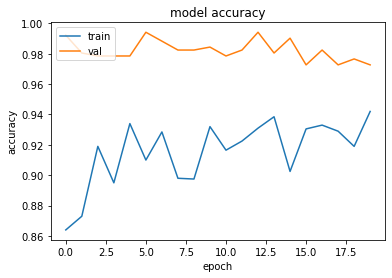

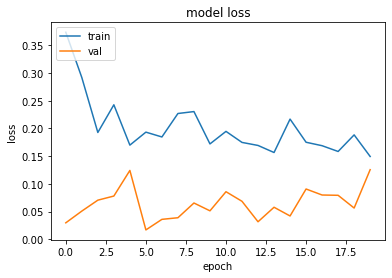

In [12]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Evaluate the model on the testset

In [13]:
model_3.evaluate(testset)

125/125 [==============================] - 8s 65ms/step - loss: 0.0491 - categorical_accuracy: 0.9860


[0.049109610220396234, 0.986]